<a href="https://colab.research.google.com/github/udupa-varun/pyimagesearch_uni/blob/main/deep_learning/105/first_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/first-cnn/first-cnn.zip
!unzip -qq first-cnn.zip
%cd first-cnn
!wget https://pis-datasets.s3.us-east-2.amazonaws.com/animals.zip
!unzip -qq animals.zip

--2023-02-22 10:10:27--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/first-cnn/first-cnn.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.132.185, 52.218.178.105, 3.5.87.149, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.132.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10378 (10K) [binary/octet-stream]
Saving to: ‘first-cnn.zip’

first-cnn.zip       100%[===================>]  10.13K  --.-KB/s    in 0s      

2023-02-22 10:10:28 (158 MB/s) - ‘first-cnn.zip’ saved [10378/10378]

/content/first-cnn
--2023-02-22 10:10:28--  https://pis-datasets.s3.us-east-2.amazonaws.com/animals.zip
Resolving pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)... 52.219.100.250
Connecting to pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.

In [2]:
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np


from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import SimplePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader

In [3]:
class ShallowNet:
    @staticmethod
    def build(width, height, depth, classes):
        # init model along with input shape to be "channels last"
        model = Sequential()
        input_shape = (height, width, depth)

        # if using "channels first", update input shape
        if K.image_data_format() == "channels_first":
            input_shape = (depth, height, width)

        # define first and only CONV => RELU layer
        model.add(
            Conv2D(
                filters=32, 
                kernel_size=(3, 3), 
                padding="same", 
                input_shape=input_shape
                )
            )
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return constructed network architecture
        return model

### ShallowNet on Animals

In [4]:
# grab list of images
print("[INFO] loading images...")
image_paths = list(paths.list_images("animals"))

# init image preprocessors
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor()

# load dataset from disk and scale raw pixel intensities to [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(image_paths, verbose=500)
data = data.astype("float") / 255.0

[INFO] loading images...
[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000


In [5]:
# partition data into train test splits (75/25)
(train_x, test_x, train_y, test_y) = train_test_split(
    data,
    labels,
    test_size=0.25,
    random_state=42
)

# convert labels from integers to vectors
train_y = LabelBinarizer().fit_transform(train_y)
test_y = LabelBinarizer().fit_transform(test_y)

In [6]:
# init optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
model.compile(
    loss="categorical_crossentropy", 
    optimizer=opt,
    metrics=["accuracy"]
    )

# train network
print("[INFO] training network...")
H = model.fit(
    train_x, 
    train_y, 
    validation_data=(test_x, test_y), 
    batch_size=32,
    epochs=100,
    verbose=1
    )

[INFO] compiling model...


[INFO] training network...
Epoch 1/100
71/71 [==============================] - 3s 30ms/step - loss: 1.0294 - accuracy: 0.4782 - val_loss: 0.9534 - val_accuracy: 0.5093
Epoch 2/100
71/71 [==============================] - 2s 23ms/step - loss: 0.8970 - accuracy: 0.5391 - val_loss: 0.8410 - val_accuracy: 0.5760
Epoch 3/100
71/71 [==============================] - 2s 25ms/step - loss: 0.8597 - accuracy: 0.5796 - val_loss: 0.9021 - val_accuracy: 0.5267
Epoch 4/100
71/71 [==============================] - 2s 23ms/step - loss: 0.8277 - accuracy: 0.5867 - val_loss: 0.8233 - val_accuracy: 0.5840
Epoch 5/100
71/71 [==============================] - 2s 23ms/step - loss: 0.8050 - accuracy: 0.5964 - val_loss: 0.9897 - val_accuracy: 0.5400
Epoch 6/100
71/71 [==============================] - 3s 38ms/step - loss: 0.7902 - accuracy: 0.6102 - val_loss: 0.8908 - val_accuracy: 0.5400
Epoch 7/100
71/71 [==============================] - 2s 27ms/step - loss: 0.7781 - accuracy: 0.6249 - val_loss: 0.7818 - 

In [7]:
# evaluate network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(
    classification_report(
        test_y.argmax(axis=1), 
        predictions.argmax(axis=1), 
        target_names=["cat", "dog", "panda"]
        )
    )

[INFO] evaluating network...
24/24 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

         cat       0.59      0.74      0.66       249
         dog       0.62      0.47      0.54       239
       panda       0.84      0.83      0.84       262

    accuracy                           0.69       750
   macro avg       0.69      0.68      0.68       750
weighted avg       0.69      0.69      0.68       750



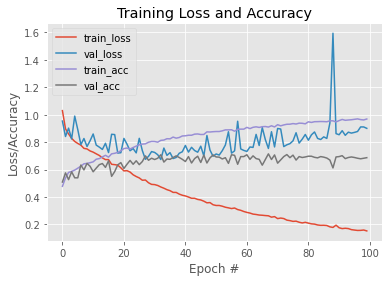

In [8]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### ShallowNet on CIFAR-10

In [9]:
# load data and rescale pixel intensities to [0, 1]
print("[INFO] loading CIFAR-10 data...")
((train_x, train_y), (test_x, test_y)) = cifar10.load_data()
train_x = train_x.astype("float") / 255.0
test_x = test_x.astype("float") / 255.0

# convert labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.fit_transform(test_y)

# init label names for CIFAR-10 dataset
label_names = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...
170498071/170498071 [==============================] - 2s 0us/step


In [10]:
# init optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=0.01)
model = ShallowNet.build(width=32, height=32, depth=3, classes=10)
model.compile(
    loss="categorical_crossentropy", 
    optimizer=opt,
    metrics=["accuracy"]
)

# train network
print("[INFO] training network...")
H = model.fit(
    train_x, 
    train_y, 
    validation_data=(test_x, test_y), 
    batch_size=32,
    epochs=40,
    verbose=1
)

[INFO] compiling model...
[INFO] training network...
Epoch 1/40
1563/1563 [==============================] - 56s 36ms/step - loss: 1.7952 - accuracy: 0.3679 - val_loss: 1.6161 - val_accuracy: 0.4278
Epoch 2/40
1563/1563 [==============================] - 45s 29ms/step - loss: 1.5391 - accuracy: 0.4626 - val_loss: 1.4760 - val_accuracy: 0.4870
Epoch 3/40
1563/1563 [==============================] - 45s 29ms/step - loss: 1.4292 - accuracy: 0.4992 - val_loss: 1.4912 - val_accuracy: 0.4744
Epoch 4/40
1563/1563 [==============================] - 44s 28ms/step - loss: 1.3518 - accuracy: 0.5277 - val_loss: 1.4000 - val_accuracy: 0.5080
Epoch 5/40
1563/1563 [==============================] - 41s 26ms/step - loss: 1.2876 - accuracy: 0.5508 - val_loss: 1.3626 - val_accuracy: 0.5144
Epoch 6/40
1563/1563 [==============================] - 42s 27ms/step - loss: 1.2413 - accuracy: 0.5665 - val_loss: 1.3193 - val_accuracy: 0.5353
Epoch 7/40
1563/1563 [==============================] - 40s 26ms/step -

In [11]:
# evaluate network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(
    classification_report(
        test_y.argmax(axis=1), 
        predictions.argmax(axis=1), 
        target_names=label_names
        )
    )

[INFO] evaluating network...
313/313 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

    airplane       0.67      0.60      0.64      1000
  automobile       0.59      0.84      0.70      1000
        bird       0.40      0.55      0.46      1000
         cat       0.38      0.53      0.45      1000
        deer       0.57      0.48      0.52      1000
         dog       0.50      0.52      0.51      1000
        frog       0.79      0.61      0.69      1000
       horse       0.82      0.54      0.65      1000
        ship       0.76      0.68      0.72      1000
       truck       0.76      0.54      0.63      1000

    accuracy                           0.59     10000
   macro avg       0.62      0.59      0.60     10000
weighted avg       0.62      0.59      0.60     10000



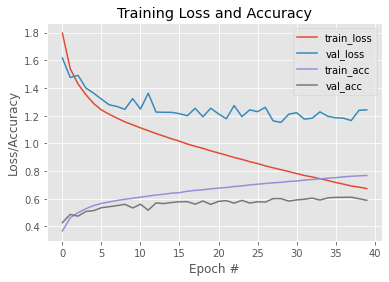

In [12]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()